In [20]:
# ==============================
# STEP 1: Split the grid into individual letter images
# ==============================
import os
import cv2
import numpy as np

# ✅ Use absolute path (raw string to avoid issues with \U)
img_path = r"C:\Users\duddu\OneDrive\Desktop\hand_gesturies.jpg"
img = cv2.imread(img_path)

# Safety check
if img is None:
    raise FileNotFoundError(f"❌ Could not load image at {img_path}. Please check the file path.")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("✅ Image loaded successfully")

# Grid info (5 rows x 5 cols = 25 letters A–Y)
rows, cols = 5, 5
h, w, _ = img.shape
cell_h, cell_w = h // rows, w // cols

# Letters included (A–Y, except J and Z in ASL)
letters = list("ABCDEFGHIKLMNOPQRSTUVWXY")

# Create dataset folder
dataset_dir = "dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Crop and save each letter
count = 0
for r in range(rows):
    for c in range(cols):
        if count >= len(letters):
            break
        letter = letters[count]
        crop = img[r*cell_h:(r+1)*cell_h, c*cell_w:(c+1)*cell_w]
        
        # Create folder for each letter
        letter_dir = os.path.join(dataset_dir, letter)
        os.makedirs(letter_dir, exist_ok=True)
        
        # Save cropped image
        cv2.imwrite(os.path.join(letter_dir, f"{letter}.jpg"), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
        
        count += 1

print("✅ Step 1 complete: Cropped images saved in dataset/")

# ==============================
# STEP 1B: Expand dataset with augmentation
# ==============================
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Expand each cropped image into ~100 samples
for letter in letters:
    img_path = os.path.join(dataset_dir, letter, f"{letter}.jpg")
    image = load_img(img_path, target_size=(64,64))
    x = img_to_array(image)
    x = np.expand_dims(x, axis=0)
    
    save_path = os.path.join(dataset_dir, letter)
    i = 0
    for batch in aug.flow(x, batch_size=1, save_to_dir=save_path, save_prefix=letter, save_format="jpg"):
        i += 1
        if i > 100:   # generate 100 augmented images per class
            break

print("✅ Step 1B complete: Augmented dataset created")

# ==============================
# STEP 2: Setup Data Augmentation & Split
# ==============================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (64, 64)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# ==============================
# STEP 3: Build CNN Model
# ==============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(64,64,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# ==============================
# STEP 4: Train Model
# ==============================
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

# ==============================
# STEP 5: Save Model
# ==============================
model.save("hand_sign_model.h5")
print("✅ Model trained and saved as hand_sign_model.h5")

# ==============================
# STEP 6: Evaluate Model
# ==============================
from tensorflow.keras.models import load_model

model = load_model("hand_sign_model.h5")

val_loss, val_acc = model.evaluate(val_data)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")

# ==============================
# STEP 7: Predict on a New Image
# ==============================
import numpy as np
import cv2

class_labels = list(train_data.class_indices.keys())

def predict_gesture(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"❌ Could not load image at {img_path}.")
    img = cv2.resize(img, (64, 64)) / 255.0
    img = np.expand_dims(img, axis=0)
    
    pred = model.predict(img)
    predicted_class = class_labels[np.argmax(pred)]
    confidence = np.max(pred)
    
    print(f"Predicted Gesture: {predicted_class} (Confidence: {confidence*100:.2f}%)")

# Example prediction on one cropped dataset image
predict_gesture("dataset/A/A.jpg")


✅ Image loaded successfully
✅ Step 1 complete: Cropped images saved in dataset/
✅ Step 1B complete: Augmented dataset created
Found 3865 images belonging to 24 classes.
Found 957 images belonging to 24 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 24)                  │           6,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,279,320 (4.88 MB)

 Trainable params: 1,279,320 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 66s 261ms/step - accuracy: 0.1917 - loss: 2.6769 - val_accuracy: 0.5225 - val_loss: 1.5502
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.5389 - loss: 1.3851 - val_accuracy: 0.8088 - val_loss: 0.6968
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.7646 - loss: 0.7013 - val_accuracy: 0.8370 - val_loss: 0.4857
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.8507 - loss: 0.4436 - val_accuracy: 0.9195 - val_loss: 0.2491
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.8952 - loss: 0.3137 - val_accuracy: 0.9394 - val_loss: 0.1767
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9151 - loss: 0.2436 - val_accuracy: 0.9383 - val_loss: 0.1853
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9343 - loss: 0.1910 - val_accuracy: 0.9561 - val_loss: 0.1388
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9485 - loss: 0.1499 -

✅ Model trained and saved as hand_sign_model.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9718 - loss: 0.0836
✅ Validation Accuracy: 97.18%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted Gesture: A (Confidence: 52.90%)


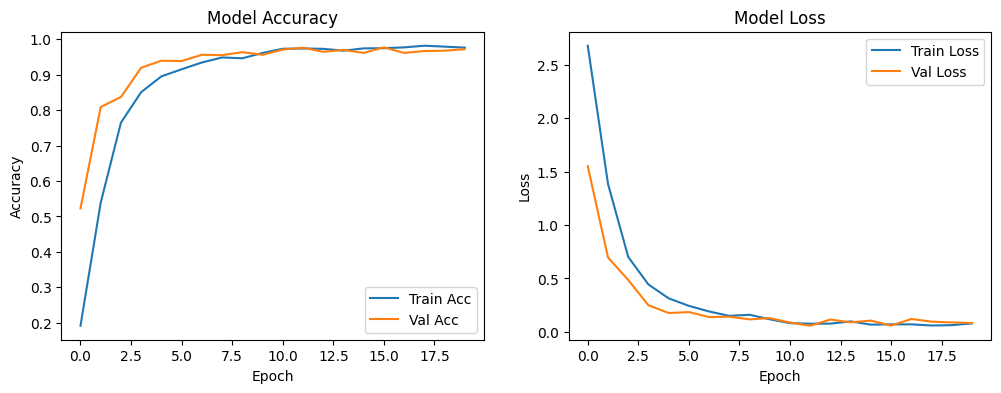

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [27]:
predict_gesture(r"C:\Users\duddu\OneDrive\Desktop\hand_gesturies.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Gesture: T (Confidence: 87.60%)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


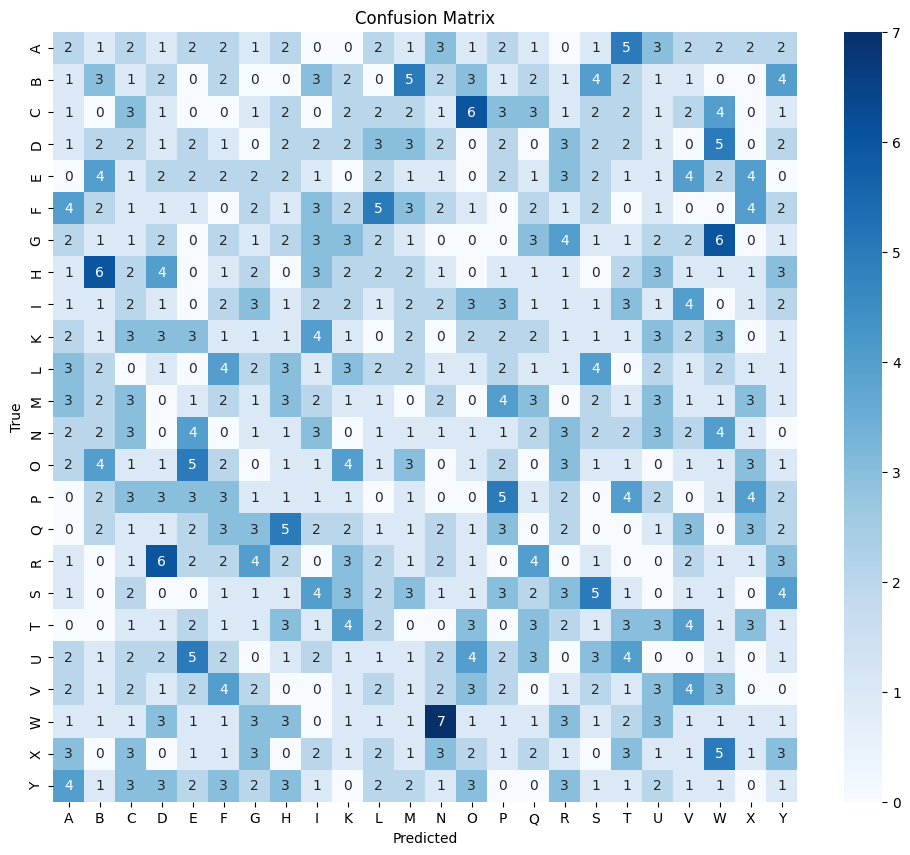

              precision    recall  f1-score   support

           A       0.05      0.05      0.05        40
           B       0.08      0.07      0.08        40
           C       0.07      0.07      0.07        40
           D       0.03      0.03      0.03        40
           E       0.05      0.05      0.05        40
           F       0.00      0.00      0.00        40
           G       0.03      0.03      0.03        40
           H       0.00      0.00      0.00        40
           I       0.05      0.05      0.05        40
           K       0.02      0.03      0.02        40
           L       0.05      0.05      0.05        40
           M       0.00      0.00      0.00        40
           N       0.03      0.03      0.03        40
           O       0.03      0.03      0.03        39
           P       0.12      0.12      0.12        40
           Q       0.00      0.00      0.00        40
           R       0.00      0.00      0.00        39
           S       0.13    

In [23]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on validation set
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(val_data.classes, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(val_data.classes, y_pred, target_names=class_labels))
